# Mapping the land model results from 1D to 2D: an example of urban landunits   
Author: Dr. Zhonghua Zheng (zhonghua.zheng@outlook.com) 

reference: https://github.com/NCAR/ctsm_python_gallery/blob/master/notebooks/PFT-Gridding.ipynb

In [1]:
import xarray as xr
import numpy as np
from numpy import empty
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

## load data

In [2]:
%%time
fn = ""
ds = xr.open_dataset(fn)

fn_ncl = ""
ds_ncl = xr.open_dataset(fn_ncl)

CPU times: user 48.4 ms, sys: 13.3 ms, total: 61.7 ms
Wall time: 122 ms


## define parameters

In [3]:
var_str = "TREFMXAV"

lat = ds.lat
lon = ds.lon
time = ds.time
ixy = ds.land1d_ixy
jxy = ds.land1d_jxy
landtype = ds.land1d_ityplunit
var = ds[var_str]

nlat = len(lat.values)
nlon = len(lon.values)
ntim   = len(time.values)
nland = np.int(np.max(landtype))+1 # land from 0 to 9, so the dimension is 10

## mapping to a NumPy array

In [4]:
%%time
# create an empty array
gridded = np.full([ntim,nland,nlat,nlon],np.nan)

# index should from 0 to max-1
gridded[:,landtype.values.astype(int),jxy.values.astype(int) - 1,ixy.values.astype(int) - 1] = var.values
print(gridded.shape)

(1, 10, 192, 288)
CPU times: user 3.44 ms, sys: 4.53 ms, total: 7.97 ms
Wall time: 42.4 ms


## create a DataArray by adding dimensions and coordinates

In [5]:
grid_dims = xr.DataArray(gridded, dims=("time","lndtype","lat","lon"))
grid_dims = grid_dims.assign_coords(time=ds.time,
                                    lndtype=[i for i in range(10)],
                                    lat=lat.values,
                                    lon=lon.values)
grid_dims.name = var_str

## show the results

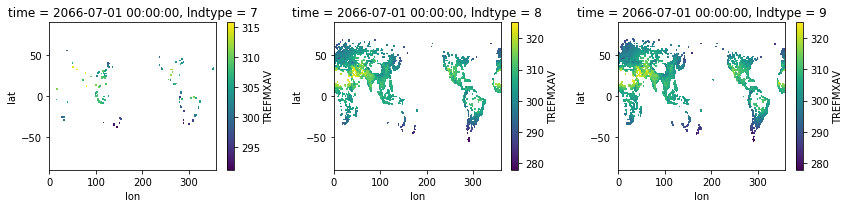

In [6]:
fig = plt.figure(figsize=(12,3))
# lndtype = 7
ax = fig.add_subplot(131)
grid_dims.sel(lndtype=7,time=ds.time[0]).plot(ax=ax)
# lndtype = 8
ax = fig.add_subplot(132)
grid_dims.sel(lndtype=8,time=ds.time[0]).plot(ax=ax)
# lndtype = 9
ax = fig.add_subplot(133)
grid_dims.sel(lndtype=9,time=ds.time[0]).plot(ax=ax)
plt.tight_layout()
plt.show()

## validate the results with NCL code

lut = 3 , lndtype = 7
Pass the test of numpy.testing.assert_array_equal!


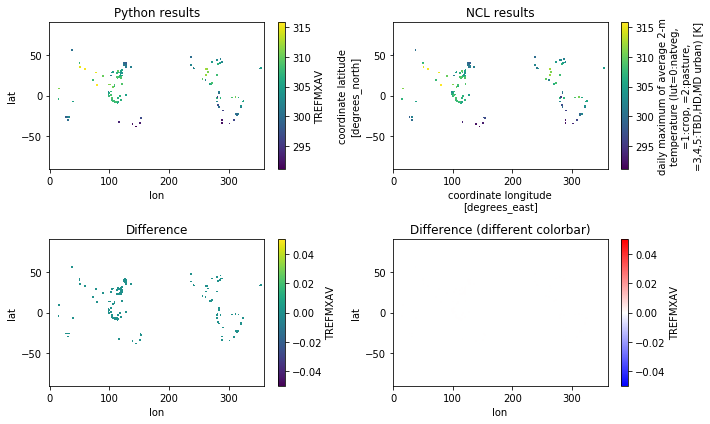

################

lut = 4 , lndtype = 8
Pass the test of numpy.testing.assert_array_equal!


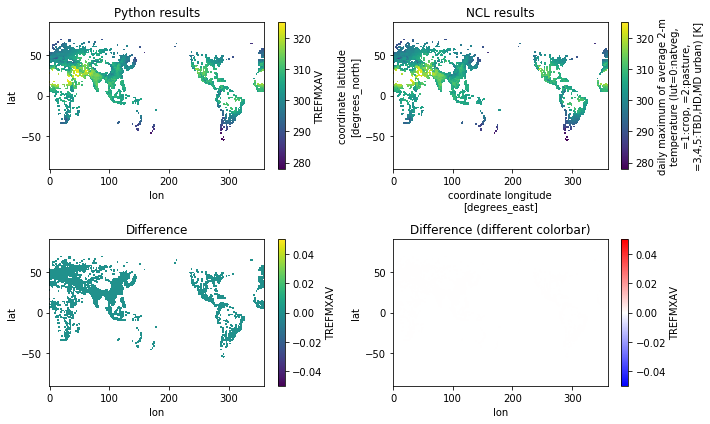

################

lut = 5 , lndtype = 9
Pass the test of numpy.testing.assert_array_equal!


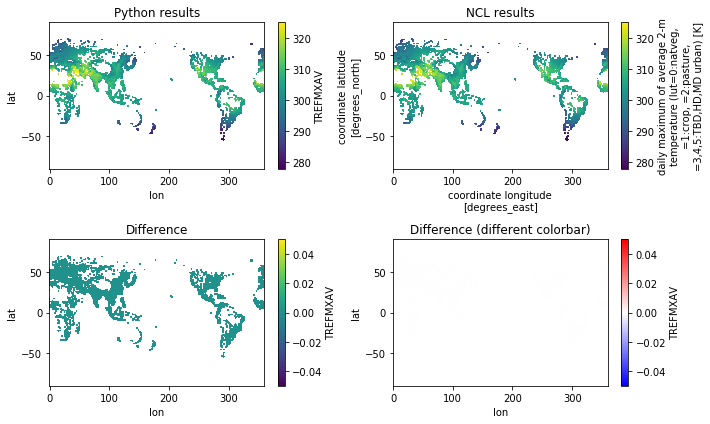

################



In [7]:
for idx in [3,4,5]:
    print("lut =", idx,", lndtype =", idx+4)
    
    c = grid_dims.sel(lndtype=(idx+4))
    r = ds_ncl["TREFMXAV"].sel(lut=idx)
    
    # Raises an AssertionError if two array_like objects are not equal.
    # https://numpy.org/doc/stable/reference/generated/numpy.testing.assert_array_equal.html
    np.testing.assert_array_equal(c.values, r.values)
    print("Pass the test of numpy.testing.assert_array_equal!")
    
    fig = plt.figure(figsize=(10,6))
    # naive implementation
    ax = fig.add_subplot(221)
    c.plot()
    ax.set_title("Python results")
    # main
    ax = fig.add_subplot(222)
    r.plot(ax=ax)
    ax.set_title("NCL results")
    # difference
    ax = fig.add_subplot(223)
    (c-r).plot()
    ax.set_title("Difference")
    # difference but with different colorbar
    ax = fig.add_subplot(224)
    (c-r).plot(cmap="bwr")
    ax.set_title("Difference (different colorbar)")
    plt.tight_layout()
    plt.show()
    
    print("################\n")